#  Modelling CpG islands with Hidden Markov Models

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#General" data-toc-modified-id="General-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General</a></span></li><li><span><a href="#Viterbi,-Forward/Backward-Algorithm" data-toc-modified-id="Viterbi,-Forward/Backward-Algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Viterbi, Forward/Backward Algorithm</a></span></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Matrices" data-toc-modified-id="Matrices-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Matrices</a></span></li><li><span><a href="#Forward-Algorithm" data-toc-modified-id="Forward-Algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forward Algorithm</a></span></li><li><span><a href="#Backward-Algorithm" data-toc-modified-id="Backward-Algorithm-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Backward Algorithm</a></span></li><li><span><a href="#Test-Sequence" data-toc-modified-id="Test-Sequence-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test Sequence</a></span></li><li><span><a href="#Test-Sequence-Modification" data-toc-modified-id="Test-Sequence-Modification-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test Sequence Modification</a></span></li></ul></div>

##  Introduction

### General

We model CpG islands by creating a Hidden Markov Model of the 1st order.
The model assumes the presence of two “hidden” states: **CpG island** and **nonCpG island**.

We estimate parameters of the model by calculating **transition, emission and initiation** probabilities. For this use sequences from the file “Sequences.txt” with the known location of CpG islands described in the file “Keys.txt”. 

Each line of the file “Sequences.txt” corresponds to a single sequence of bases “A”, “T”, “G” and “C”. The file contains 500 sequences in total. 

The file “Keys.txt” specifies states of sequence bases: “+” – the base belongs to a CpG island, “-” – the base does not belong to a CpG island. 

Note that in this exercise we do not require that the emission of the base at the
position i depends on the base at the position i+1.


look in most probable state for an observation

###  Viterbi, Forward/Backward Algorithm

1. **Transition probability:** go from state k to state l: 𝑎𝑎𝑘𝑘,𝑙𝑙 = 𝑃𝑃(𝜋𝜋𝑖𝑖 = 𝑙𝑙 | 𝜋𝜋𝑖𝑖−1 = 𝑘𝑘) 


2. **Emission probabilities:** emit a base 𝛽𝛽 at state l: 𝑒𝑒𝑙𝑙(𝛽𝛽) = 𝑃𝑃(𝑥𝑥𝑖𝑖 = 𝛽𝛽 | 𝜋𝜋𝑖𝑖 = 𝑙𝑙) 


3. **Initiation probability:** genomic sequence starts at certain state (CpG or non-CpG)

## Imports

In [3]:
from matplotlib.patches import Rectangle
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transitions = np.zeros((2, 2))  # +- / +-
emissions = np.zeros((4, 2))  # +- / ACTG
initiations = np.zeros((1, 2))  # +- / Probability

## Matrices

In [7]:
sequences = pd.read_csv('Sequences.txt', header=None)[0]
keys = pd.read_csv('keys.txt', header=None)[0]
keys_ohe = [x.replace('+', "1").replace('-', "0") for x in keys]  # binary
totals = [60278, 29119]

# Transition Array
for i in range(2):
    for x in range(2):
        query = str(i)+str(x)
        transitions[i][x] = np.sum(
            [len(re.findall('(?=%s)' % query, keys_ohe[n])) for n in range(len(keys))])/totals[i]

print('Transitions: -+ / -+')
print(transitions)
print('\n')
non_cpgs = [[m.start() for m in re.finditer('0', n)] for n in keys_ohe]
cpgs = [[m.start() for m in re.finditer('1', n)] for n in keys_ohe]

cp_nuc = [[sequences[r][i] for i in cpgs[r]] for r in range(len(sequences))]
non_cp_nuc = [[sequences[r][i] for i in non_cpgs[r]]
              for r in range(len(sequences))]
states = [non_cp_nuc, cp_nuc]
nucs = ['A', 'T', 'G', 'C']
totals2 = [np.sum([len(x) for x in non_cp_nuc]),
           np.sum([len(x) for x in cp_nuc])]

# Emisssion Array
for nuc in range(len(nucs)):
    for state in range(len(states)):
        emissions[nuc][state] = np.sum(
            [n.count(nucs[nuc]) for n in states[state]])/totals2[state]

print('Emissions: ATGC/-+')
print(emissions)
print('\n')

# Initiation Array (occurence in sequence)
pos = np.sum([int(n[0]) for n in keys_ohe])
initiations = [pos/500, 1-pos/500]

print('Initiations: -+/Probabilites')
print(initiations)

Transitions: -+ / -+
[[0.9871429  0.0128571 ]
 [0.02558467 0.97441533]]


Emissions: ATGC/-+
[[0.25910751 0.14164113]
 [0.26115618 0.14501192]
 [0.24023989 0.35263875]
 [0.23949642 0.36070821]]


Initiations: -+/Probabilites
[0.442, 0.558]


Using Viterbi algorithm we find the most likely assignment of CpG islands in the
“Test_sequence”.

## Forward Algorithm

In [59]:
def forward(sequence, initmat, a, e):
    states = [0, 1]
    seqlen = len(sequence)
    f = [[0]*seqlen, [0]*seqlen]
    ptr = [[0]*seqlen]
    nucleotide = {"A": 0, "T": 1, "G": 2, "C": 3}
    for k in states:
        f[k][0] = initmat[k]*e[k][nucleotide[sequence[0]]]
    for i in range(1, seqlen):
        for k in states:
            # Sum of both last previous probs*transitions for each state
            f[k][i] = f[states[0]][i-1]*a[states[0]][k]
            # Remaining state
            for l in states[1:]:
                f[k][i] += f[l][i-1]*a[l][k]
            f[k][i] = f[k][i]*e[k][nucleotide[sequence[i]]]
    return f

## Backward Algorithm

In [61]:
def backward(sequence, initmat, a, e):

    states = [0, 1]
    seqlen = len(sequence)
    b = [[0]*seqlen, [0]*seqlen]
    nucleotide = {"A": 0, "T": 1, "C": 2, "G": 3}

    for k in states:
        b[k][-1] = 1

    for i in np.arange(seqlen-2, -1, -1):
        # -1 for index shift, -1 for second last column

        for k in states:
            b[k][i] = b[states[0]][i+1] * a[k][states[0]] * \
                e[states[0]][nucleotide[sequence[i+1]]]

            # Remaining state
            for l in states[1:]:
                b[k][i] += b[l][i+1]*a[k][l]*e[l][nucleotide[sequence[i+1]]]
            b[k][i] = b[k][i]

    start = 0
    for k in states:
        start += b[k][0]*e[k][nucleotide[sequence[0]]]*initmat[k]

    return b

## Test Sequence

In [62]:
test_sequence="AACAATAATTTTGTTCTCCAATATAATCATCGACGCGTCGCGACGCGCGGGGGCGCCGGGTGACCCTATACTTCACTTGAATGCCATCCG"

In [63]:
states = [0,1]
start_p = [0.558, 0.442]
trans_p = [[0.9871429, 0.0128571], [0.02558467, 0.97441533]]
emit_p = [[0.25910751, 0.26115618, 0.24023989, 0.23949642],
          [0.14164113, 0.14501192, 0.35263875, 0.36070821]]

For every base of the “Test_sequence” calculate the probability to be in a CpG island. Use Forward and Backward algorithms. Calculate the probability of the “Test_sequence” using Forward and Backward algorithms. Obtained values should be the same. Plot the result: x-axis defines the position of the base, the y-axis defines the probability of the base to be in a CpG island.

In [64]:
f1 = forward(test_sequence, start_p, trans_p, emit_p)
b1 = backward(test_sequence, start_p, trans_p, emit_p)
probs = np.multiply(f1, b1) / np.sum(f1, axis=0)[-1]

island = ["-"]*len(test_sequence)
state=np.argmax(probs1,axis=0)
for i in range(len(test_sequence)):
        if state[i]==1: 
            island[i]="+"    
print('Most likely states: ' + "".join(island))



Most likely states: --------------------------------++++++++++++++++++++++++++++++++--------------------------


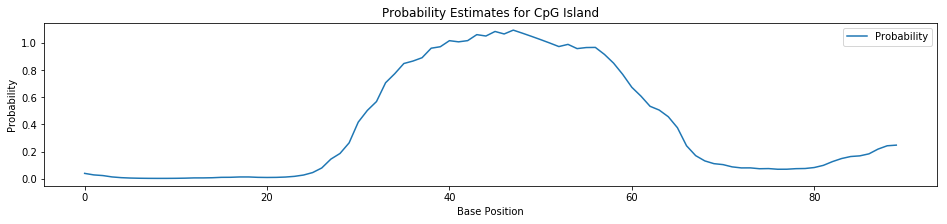

In [65]:
plt.figure(figsize=(16, 3))
plt.plot(probs[1],  label='Probability')
plt.title('Probability Estimates for CpG Island')
plt.xlabel('Base Position')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()

## Test Sequence Modification

Change a single letter of the “Test_sequence” from G to T (red):

In [56]:
test_sequence2="AACAATAATTTTGTTCTCCAATATAATCATCGACGCGTCGCGACTCGCGGGGGCGCCGGGTGACCCTATACTTCACTTGAATGCCATCCG"

In [57]:
f2 = forward(test_sequence2, start_p, trans_p, emit_p)
b2 = backward(test_sequence2, start_p, trans_p, emit_p)
probs2 = np.multiply(f2, b2) / np.sum(f2, axis=0)[-1]

island2 = ["-"]*len(test_sequence2)
state2=np.argmax(probs2,axis=0)
for i in range(len(test_sequence2)):
        if state2[i]==1: 
            island2[i]="+"    
print('Most likely states: ' + "".join(island2))

Most likely states: ---------------------------------+++++++++++++++++++++++++++++++--------------------------


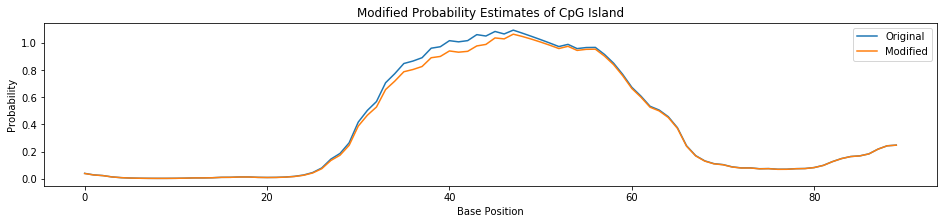

In [58]:
plt.figure(figsize=(16, 3))
plt.plot(probs[1],  label='Original')
plt.plot(probs2[1],  label='Modified')
plt.title('Modified Probability Estimates of CpG Island')
plt.xlabel('Base Position')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()

Run Viterbi, Forward and Backward algorithms for the modified “Test_sequence”. For every base of the “Test_sequence” calculate the probability to be in a CpG island. Discuss the impact of the modification of one letter of the “Test_sequence” on the performance of Viterbi algorithm and on the probability of bases to belong to a CpG island.

**Answer:**

Changing a single nucleotide affects neighbors because we use the forward/backward algorithm.